In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/My\ Drive/indian-pines-hyperspectral-dataset.zip .
!cp /content/drive/My\ Drive/models/model_0698.h5 .

In [0]:
!unzip indian-pines-hyperspectral-dataset.zip

Archive:  indian-pines-hyperspectral-dataset.zip
  inflating: indianpinearray.npy     
  inflating: IPgt.npy                


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import keras.backend as K
K.set_learning_phase(1)

In [0]:
from keras import applications, layers

class FrozenBatchNormalization(layers.BatchNormalization):
    def call(self, inputs, training=None):
        return super().call(inputs=inputs, training=False)

# Keep a copy of the original class
BatchNormalization = layers.BatchNormalization

# Patch the class temporarily
layers.BatchNormalization = FrozenBatchNormalization

In [0]:
import numpy as np
data = np.load('indianpinearray.npy')
gt = np.load('IPgt.npy')
gt = gt.flatten()


In [0]:
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model,Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D,Conv1D,multiply
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers.convolutional import UpSampling2D, Conv2D, UpSampling1D
from keras.initializers import RandomNormal
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from skimage.color import label2rgb
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def define_discriminator(in_shape=(10,1), n_classes=17):
	model = Sequential()

	model.add(Conv1D(256, kernel_size=4, strides=1, input_shape=in_shape, padding="same"))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv1D(512, kernel_size=4, strides=1, padding="same"))
	model.add(LeakyReLU(alpha=0.2))
	model.add(BatchNormalization(momentum=0.8))

	model.add(Conv1D(128, kernel_size=4, strides=1, padding="same"))

	model.add(Flatten())
	model.summary()

	img = Input(shape=in_shape)
	features = model(img)
	validity = Dense(1, activation="sigmoid")(features)
	label = Dense(n_classes, activation="softmax")(features)
	model = Model(img, [validity, label])
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.summary()
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt, metrics=['accuracy'])
	return model

In [0]:
def define_generator(latent_dim, n_classes=17):

	model = Sequential()
	model.add(Dense(512, activation="relu", input_dim=latent_dim))
	model.add(Reshape((1, 512)))
	model.add(BatchNormalization(momentum=0.8))
	model.add(UpSampling1D())
	model.add(Conv1D(512, kernel_size=4, padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(momentum=0.8))
	model.add(UpSampling1D(size=5))
	model.add(Conv1D(128, kernel_size=4, padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(momentum=0.8))
	model.add(Conv1D(1, kernel_size=4, padding='same'))
	model.add(Activation("tanh"))
	model.summary()

	noise = Input(shape=(latent_dim,))
	label = Input(shape=(1,), dtype='int32')
	label_embedding = Flatten()(Embedding(n_classes, latent_dim)(label))

	model_input = multiply([noise, label_embedding])
	img = model(model_input)

	return Model([noise, label], img)

In [0]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	gan_output = d_model(g_model.output)
	model = Model(g_model.input, gan_output)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model



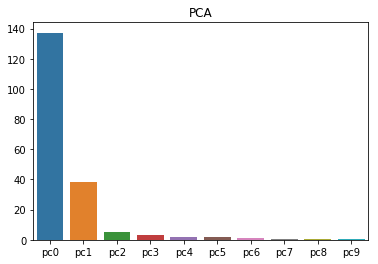

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

voxel = data.reshape(-1,data.shape[2])
scaler = StandardScaler()
voxel = scaler.fit_transform(voxel)
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(voxel)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc'+str(x) for x in range(10)])
fullDataX = principalDf
fullDataY = pd.DataFrame(data=gt)
X_train, X_test, y_train, y_test = train_test_split(principalDf, pd.DataFrame(data=gt), test_size=0.20)
ax = sns.barplot( x=["pc"+str(i) for i in range(10)],y=pca.explained_variance_)
ax.set_title("PCA")


def generate_real_test_samples(n_samples):
	images, labels =  X_test,y_test
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images.iloc[ix], labels.iloc[ix]
	X = X.to_numpy().reshape(n_samples,10,1)
	y = ones((n_samples, 1))
	return [X, labels], y

def generate_real_samples(n_samples):
	images, labels =  X_train, y_train
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images.iloc[ix], labels.iloc[ix]
	X = X.to_numpy().reshape(n_samples,10,1)
	y = ones((n_samples, 1))
	return [X, labels], y

def generate_latent_points(latent_dim, n_samples, n_classes=17):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))
	return [images, labels_input], y

def summarize_performance(step, g_model, latent_dim):
	filename = 'model_%04d.h5' % (step+1)
	g_model.save_weights(filename)
	



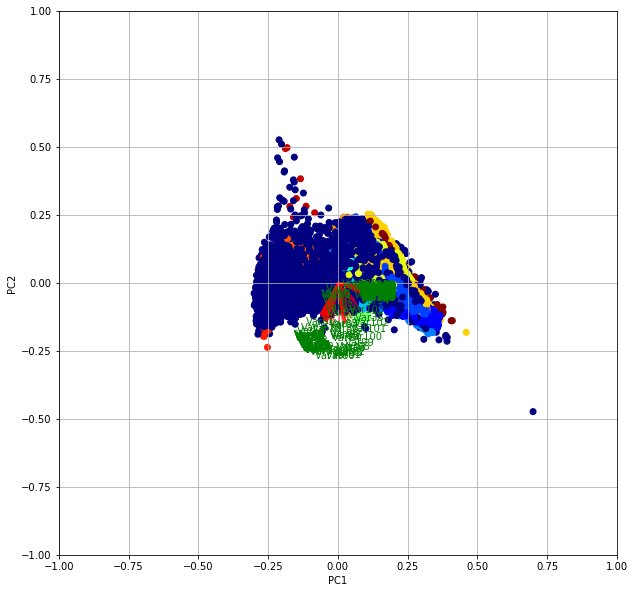

In [0]:
def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    fig, ax = plt.subplots(figsize=(10,10))
    plt.scatter(xs * scalex,ys * scaley,c=fullDataY.to_numpy().reshape(-1,),cmap="jet")
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.75, coeff[i,1] * 1.75, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.75, coeff[i,1] * 1.75, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
  
biplot(principalComponents[:,0:2],np.transpose(pca.components_[0:2, :]))

In [0]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(X_train, y_train) 

y_pred = clf.predict(X_test)

macro = f1_score(y_test, y_pred, average='macro')
micro = f1_score(y_test, y_pred, average='micro')
weighted = f1_score(y_test, y_pred, average='weighted')
print("Micro: ", micro)
print("Macro: ", macro)
print("Weighted: ", weighted)
print("Accuracy: ", accuracy_score(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Micro:  0.6913198573127229
Macro:  0.3950280731180826
Weighted:  0.6363955822185554
Accuracy:  0.6913198573127229


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Confusion Matrix')

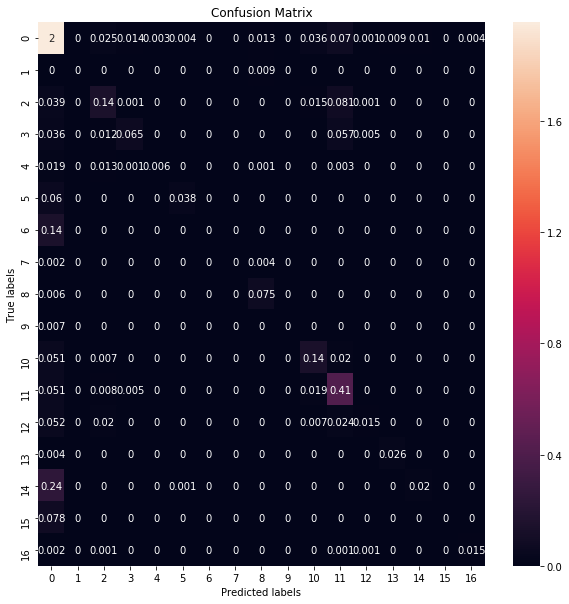

In [0]:
cm = confusion_matrix(y_test, y_pred)
cm = cm/1000
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [0]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=400, n_batch=2048):
	import warnings
	warnings.filterwarnings("ignore")
	bat_per_epo = int(15000 / n_batch)
	n_steps = bat_per_epo * n_epochs
	half_batch = int(n_batch / 2)
	prev_acc1 = 0.20
	prev_acc2 = 0.20
	for i in range(n_steps):
		[X_real, labels_real], y_real = generate_real_samples( half_batch)
		print(labels_real.shape)
		d_loss_real = d_model.train_on_batch(X_real, [y_real, labels_real])
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss_fake = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		y_gan = ones((n_batch, 1))
		g_loss = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		op_acc = d_loss[4]
		print ("Training Metrics: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
		print ( "Validating on test set" )

		# [X_treal, labels_treal], y_treal = generate_real_test_samples(half_batch)
		# d_loss_real = d_model.test_on_batch(X_treal, [y_treal, labels_treal])
	
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss = d_model.test_on_batch(X_fake, [y_fake, labels_fake])
		#d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
	
		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		y_gan = ones((n_batch, 1))
		g_loss = gan_model.test_on_batch([z_input, z_labels], [y_gan, z_labels])
	
		print ("Validation Metrics: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
	
		# if (op_acc > prev_acc1 and d_loss[4]>prev_acc2):
		# 	prev_acc1 = op_acc
		# 	prev_acc2 = d_loss[4]
		# 	summarize_performance(i, d_model, latent_dim)
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, d_model, latent_dim)

In [0]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)

discriminator.trainable = False
gan_output = discriminator(generator.output)
gan_model = Model(generator.input, gan_output)
opt = Adam(lr=0.002, beta_1=0.5)
gan_model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
  
#dataset = load_data()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 10, 256)           1280      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 10, 256)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 10, 512)           524800    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 10, 512)           0         
_________________________________________________________________
frozen_batch_normalization_6 (None, 10, 512)           2048      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 10, 128)           262272    
_________________________________________________________________
flatten_4 (Flatten)          (None, 1280)             

In [0]:
train(generator, discriminator, gan_model, latent_dim)

(1024, 1)


Training Metrics: 0 [D loss: 3.525901, acc.: 31.93%, op_acc: 7.03%] [G loss: 3.523215]
Validating on test set
Validation Metrics: 0 [D loss: 3.549351, acc.: 0.00%, op_acc: 6.54%] [G loss: 3.503699]
(1024, 1)
Training Metrics: 1 [D loss: 3.290110, acc.: 50.00%, op_acc: 27.83%] [G loss: 3.506094]
Validating on test set
Validation Metrics: 1 [D loss: 3.607728, acc.: 0.00%, op_acc: 7.23%] [G loss: 3.455691]
(1024, 1)
Training Metrics: 2 [D loss: 3.121123, acc.: 50.00%, op_acc: 30.32%] [G loss: 3.534095]
Validating on test set
Validation Metrics: 2 [D loss: 3.532652, acc.: 5.47%, op_acc: 5.96%] [G loss: 3.534230]
(1024, 1)
Training Metrics: 3 [D loss: 2.914962, acc.: 100.00%, op_acc: 30.37%] [G loss: 3.687427]
Validating on test set
Validation Metrics: 3 [D loss: 3.436670, acc.: 100.00%, op_acc: 4.98%] [G loss: 3.633785]
(1024, 1)
Training Metrics: 4 [D loss: 2.729887, acc.: 100.00%, op_acc: 32.52%] [G loss: 3.742366]
Validating on test set
Validation Metrics: 4 [D loss: 3.49413

In [0]:
from keras.models import load_model
GAN = define_discriminator()
GAN.load_weights("model_0698.h5")




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 256)           1280      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 512)           524800    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 10, 512)           0         
_________________________________________________________________
frozen_batch_normalization_1 (None, 10, 512)           2048      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 128)           262272    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)           

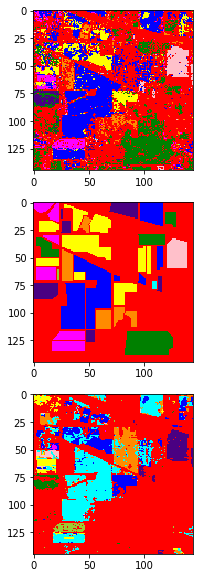

In [0]:


label_image = GAN.predict( fullDataX.to_numpy().reshape(145*145,10,1) )
label_image = np.array(label_image[1])
y = []
for t in label_image:
  y.append(np.argmax(t))
label_image = np.array(y).reshape(145,145)
image_label_overlay = label2rgb(label_image)
fig, (ax1, ax2, ax3)  = plt.subplots(3,figsize=(10, 10))

ax1.imshow(image_label_overlay)
image_label_overlay = label2rgb(fullDataY.to_numpy().reshape(145,145))
ax2.imshow(image_label_overlay)
image_label_overlay = label2rgb(clf.predict(fullDataX.to_numpy()).reshape(145,145)  )
ax3.imshow(image_label_overlay)